# Rescheduling mit Tardiness (Summe)
> Planunghorizont Tag 0: 2 Tage
> Rescheduling des Tages 1

In [2]:
max_time = 60*30 # 1/2h

In [3]:
import time

In [4]:
from ortools.sat.python import cp_model
import pandas as pd
import numpy as np
import math

pd.set_option('display.max_rows', 20)

In [5]:
import utils.presenter as show
import utils.checker as check

import utils.schedule_interarrival as sit
import utils.scheduling_solver as ssv
import utils.rescheduling_solver_tardiness as rssv

from ProductionDaySimulation import ProductionDaySimulation

In [6]:
import utils.rolling_planning.init_jobs_times as rp_init
import utils.schedule_deadline as deadline_gen

In [7]:
df_instance = pd.read_csv("data/00_instance.csv")
df_instance

,Job,Operation,Machine,Processing Time
0,job 0,0,M0,29
1,job 0,1,M1,78
2,job 0,2,M2,9
3,job 0,3,M3,36
4,job 0,4,M4,49
...,...,...,...,...
95,job 9,5,M9,76
96,job 9,6,M5,47
97,job 9,7,M3,52
98,job 9,8,M4,90


In [8]:
df_jssp, df_arrivals = rp_init.init_jobs_with_arrivals(df_instance, 2,  u_b_mmax = 0.95)
df_jssp

,Job,Operation,Machine,Processing Time
0,Job_000,0,M0,29
1,Job_000,1,M1,78
2,Job_000,2,M2,9
3,Job_000,3,M3,36
4,Job_000,4,M4,49
...,...,...,...,...
375,Job_037,5,M9,76
376,Job_037,6,M5,47
377,Job_037,7,M3,52
378,Job_037,8,M4,90


In [9]:
df_times = deadline_gen.get_times_df(df_jssp, df_arrivals, ssv.schedule_fcfs_with_arrivals, target_service=1.0)
df_times["Arrival"] = np.floor(df_times["Arrival"]).astype(int)
df_times["Deadline"] = np.ceil(df_times["Deadline"]).astype(int)
df_times

,Job,Arrival,Deadline
0,Job_000,0,1042
1,Job_001,83,1428
2,Job_002,144,1642
3,Job_003,197,1924
4,Job_004,233,1270
...,...,...,...
33,Job_033,2568,4295
34,Job_034,2574,3611
35,Job_035,2575,4073
36,Job_036,2694,3736


## I) Complete Scheduling

In [11]:
starting_time = time.time()

# Scheduling
df_plan = ssv.solve_cp_jssp_sum_tardiness(df_jssp, df_times, msg=False, timeLimit=max_time, gapRel= 0.00)
df_plan

# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")
df_plan


Solver-Status: OPTIMAL
Summe Tardiness     : 0.0
Best Objective Bound: 0.0
Laufzeit            : 2.81 Sekunden

Scheduling-Dauer: 0 Minuten und 3.69 Sekunden.


,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Tardiness
0,Job_000,0,0,1042,M0,0,29,29,0
1,Job_000,1,0,1042,M1,29,78,107,0
2,Job_001,0,83,1428,M0,83,43,126,0
3,Job_000,2,0,1042,M2,107,9,116,0
4,Job_000,3,0,1042,M3,116,36,152,0
...,...,...,...,...,...,...,...,...,...
375,Job_035,8,2575,4073,M9,3435,45,3480,0
376,Job_033,8,2568,4295,M9,3480,22,3502,0
377,Job_035,9,2575,4073,M4,3480,33,3513,0
378,Job_033,9,2568,4295,M5,3502,43,3545,0


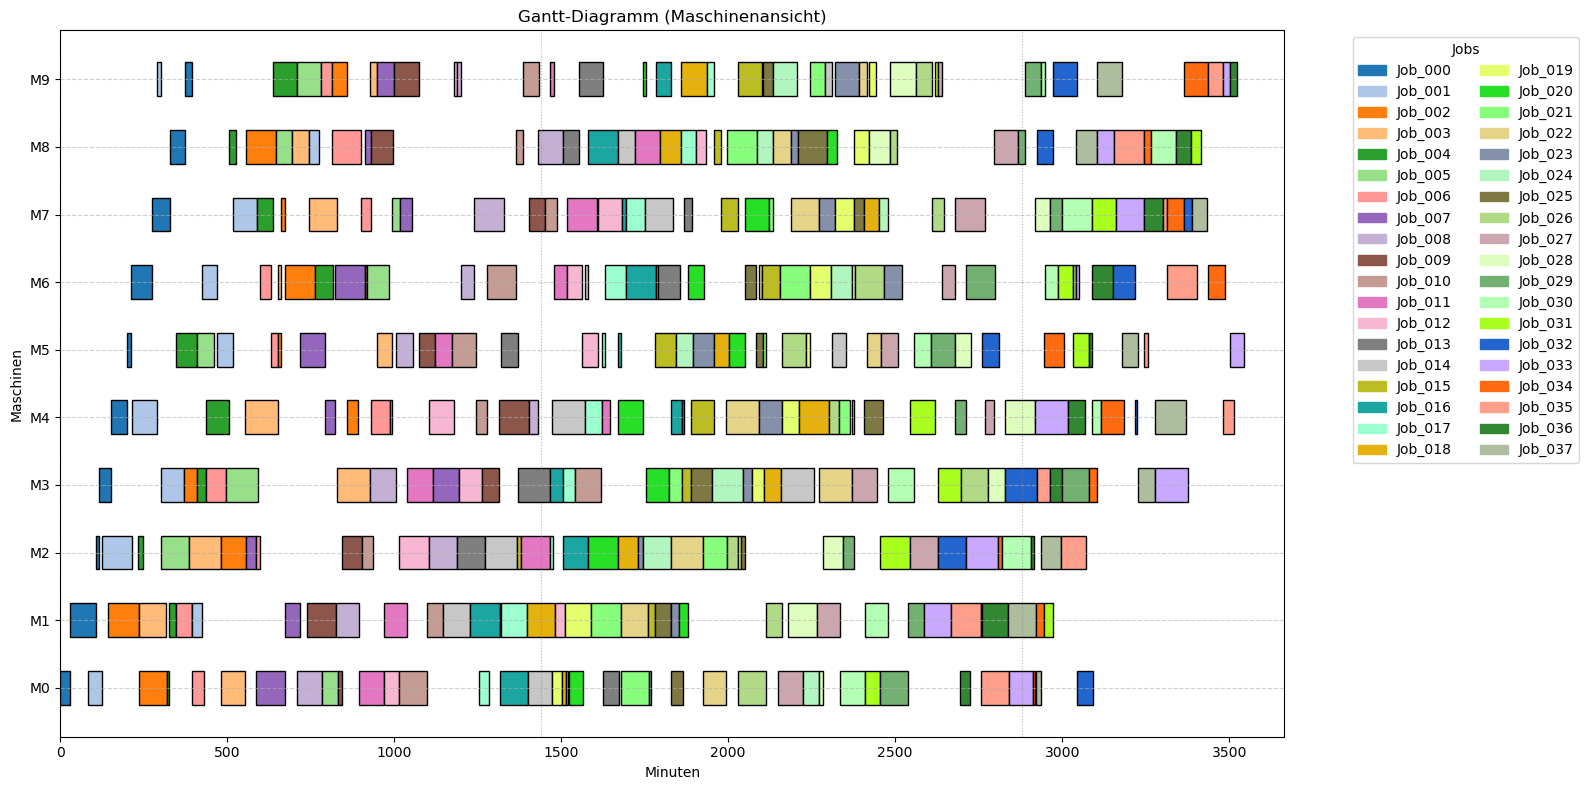

+ Keine Maschinenkonflikte gefunden
+ Für alle Jobs ist die Operationssequenz korrekt.
+ Zeitliche technologische Reihenfolge korrekt.
+ Alle Operation starten erst nach Arrival des Job


True

In [12]:
show.plot_gantt_machines(df_plan)

check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)
check.is_start_correct(df_plan)

## II) Erster Tag (Tag 0)

### a) Simulation

In [15]:
day_length = 1440

In [16]:
day_numb = 0

day_start = day_length*day_numb 
day_end = day_start + day_length

In [17]:
simulation = ProductionDaySimulation(df_plan, vc=0.35)
df_execution, df_undone = simulation.run(start_time = day_start, end_time=day_end)

[00:00:00] Job_000 started on M0
[00:13:11] Job_000 finished on M0 (after 13 minutes 12 seconds)
[00:29:00] Job_000 started on M1
[01:23:00] Job_001 started on M0
[01:58:19] Job_001 finished on M0 (after 35 minutes 20 seconds)
[02:06:00] Job_001 started on M2
[02:16:13] Job_000 finished on M1 (after 107 minutes 13 seconds)
[02:24:00] Job_002 started on M1
[04:01:14] Job_002 finished on M1 (after 97 minutes 14 seconds)
[04:01:14] Job_003 started on M1
[04:01:14] Job_002 started on M0
[04:19:52] Job_001 finished on M2 (after 133 minutes 52 seconds)
[04:19:52] Job_000 started on M2
[04:19:52] Job_001 started on M4
[04:27:41] Job_000 finished on M2 (after 07 minutes 49 seconds)
[04:27:41] Job_004 started on M2
[04:27:41] Job_000 started on M3
[04:46:51] Job_004 finished on M2 (after 19 minutes 10 seconds)
[04:55:25] Job_000 finished on M3 (after 27 minutes 44 seconds)
[05:02:00] Job_005 started on M2
[05:21:54] Job_001 finished on M4 (after 62 minutes 02 seconds)
[05:21:54] Job_000 started

In [18]:
df_undone

,Job,Operation,Arrival,Machine,Planned Start,Processing Time
0,Job_010,6,845,M8,1366,19
1,Job_015,0,1134,M2,1367,14
2,Job_013,3,1123,M3,1371,95
3,Job_011,4,894,M2,1381,85
4,Job_010,7,845,M9,1385,48
...,...,...,...,...,...,...
254,Job_035,8,2575,M9,3435,45
255,Job_033,8,2568,M9,3480,22
256,Job_035,9,2575,M4,3480,33
257,Job_033,9,2568,M5,3502,43


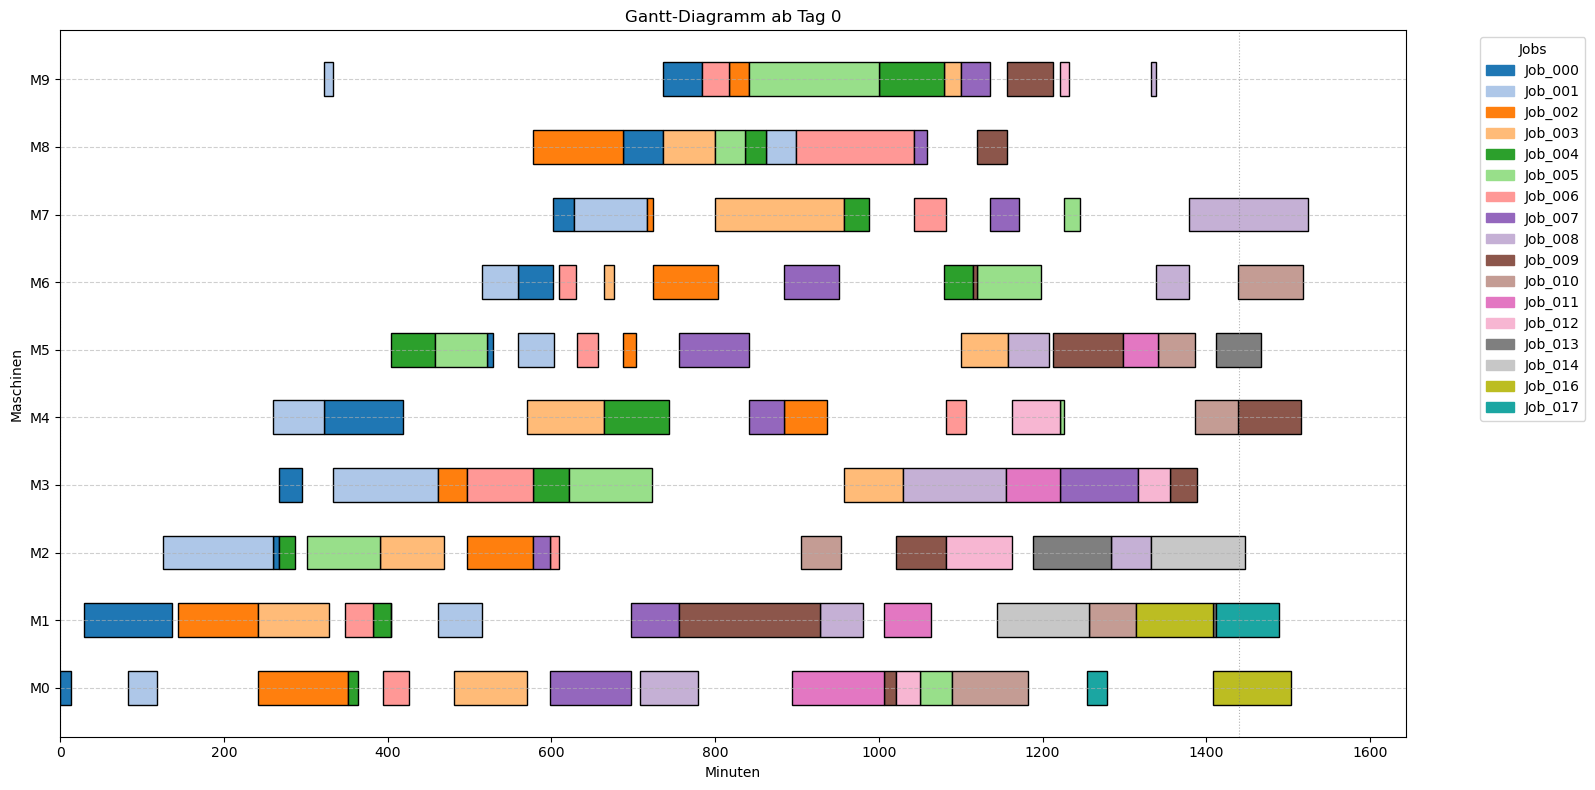

In [19]:
if not df_execution.empty:
    show.plot_gantt_machines(df_execution, title=f"Gantt-Diagramm ab Tag {day_numb}", duration_column="Simulated Processing Time")
else:
    print(f"Nothing executed on day {day_numb}")

### b) Verbleibene Jobs (Rest)

In [21]:
df_rest = df_plan.merge(df_execution[["Job", "Machine"]], on=["Job", "Machine"], how="left", indicator=True)
df_rest = df_rest[df_rest["_merge"] == "left_only"].drop(columns=["_merge"])
df_rest = df_rest.sort_values(by=["Arrival", "Start"]).reset_index(drop=True)
df_rest

,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Tardiness
0,Job_008,8,708,2283,M4,1405,26,1431,0
1,Job_008,9,708,2283,M8,1431,74,1505,0
2,Job_009,9,740,2165,M7,1405,45,1450,0
3,Job_010,6,845,2266,M8,1366,19,1385,0
4,Job_010,7,845,2266,M9,1385,48,1433,0
...,...,...,...,...,...,...,...,...,...
254,Job_037,5,2794,4218,M9,3104,76,3180,0
255,Job_037,6,2794,4218,M5,3180,47,3227,0
256,Job_037,7,2794,4218,M3,3227,52,3279,0
257,Job_037,8,2794,4218,M4,3279,90,3369,0


In [22]:
allowed = df_rest["Job"].unique() 
df_time_rest = df_times[df_times["Job"].isin(allowed)].copy()
df_time_rest

,Job,Arrival,Deadline
8,Job_008,708,2283
9,Job_009,740,2165
10,Job_010,845,2266
11,Job_011,894,2469
12,Job_012,950,2296
...,...,...,...
33,Job_033,2568,4295
34,Job_034,2574,3611
35,Job_035,2575,4073
36,Job_036,2694,3736


## III) Rescheduling
> vereinfacht, ohne neu Aufträge (nur der Rest)

In [24]:
# Reduktion der bereits ausgeführten Operationen auf die relevanten für die nächsten Tage
df_execution_important = df_execution[df_execution["End"] >= 1440]
df_execution_important

,Job,Operation,Arrival,Machine,Start,Simulated Processing Time,Flow time,End
87,Job_008,7,708,M7,1378.49,145.58,816.07,1524.07
96,Job_009,8,740,M4,1438.87,76.62,775.49,1515.49
102,Job_010,5,845,M6,1438.87,79.39,673.26,1518.26
114,Job_013,2,1123,M5,1411.49,55.94,344.43,1467.43
116,Job_014,1,1128,M2,1333.04,114.86,319.90,1447.90
118,Job_016,1,1135,M0,1408.28,95.85,369.13,1504.13
120,Job_017,1,1254,M1,1411.49,77.82,235.31,1489.31


In [25]:
# ende aufrunden

In [26]:
from ortools.sat.python import cp_model
import pandas as pd
import math

def has_solution(solver, any_var):
    try:
        _ = solver.Value(any_var)
        return True
    except:
        return False

def solve_cp_jssp_sum_tardiness_with_fixed_ops(df_jssp: pd.DataFrame,
                                                df_arrivals_deadlines: pd.DataFrame,
                                                df_executed: pd.DataFrame,
                                                reschedule_start: float = 1440.0,
                                                sort_ascending: bool = False,
                                                msg: bool = False,
                                                timeLimit: int = 3600,
                                                gapRel: float = 0.0) -> pd.DataFrame:
    model = cp_model.CpModel()

    # === Vorbereitung: Ankunfts- und Deadline-Daten ===
    df_arrivals_deadlines = df_arrivals_deadlines.sort_values("Deadline", ascending=sort_ascending).reset_index(drop=True)
    arrival = df_arrivals_deadlines.set_index("Job")["Arrival"].to_dict()
    deadline = df_arrivals_deadlines.set_index("Job")["Deadline"].to_dict()
    jobs = df_arrivals_deadlines["Job"].tolist()

    # === Operationen gruppieren und Maschinenmenge bestimmen ===
    ops_grouped = df_jssp.sort_values(["Job", "Operation"]).groupby("Job")
    all_ops, machines = [], set()
    for job in jobs:
        seq = []
        for _, row in ops_grouped.get_group(job).iterrows():
            op_id = int(row["Operation"])
            m = str(row["Machine"])
            d = int(round(row["Processing Time"]))
            seq.append((op_id, m, d))
            machines.add(m)
        all_ops.append(seq)

    # === Planungshorizont grob schätzen ===
    horizon = int(df_jssp["Processing Time"].sum() + max(deadline.values()))

    # === Feste Operationen auf Maschinen vorbereiten (aus df_executed) ===
    df_executed_fixed = df_executed[df_executed["End"] >= reschedule_start]
    fixed_ops = {
        m: list(grp[["Start", "End"]].itertuples(index=False, name=None))
        for m, grp in df_executed_fixed.groupby("Machine")
    }

    # === Variablen definieren ===
    starts, ends, intervals = {}, {}, {}
    for j, job in enumerate(jobs):
        for o, (op_id, m, d) in enumerate(all_ops[j]):
            suffix = f"{j}_{o}"
            start = model.NewIntVar(0, horizon, f"start_{suffix}")
            end = model.NewIntVar(0, horizon, f"end_{suffix}")
            interval = model.NewIntervalVar(start, d, end, f"interval_{suffix}")
            starts[(j, o)] = start
            ends[(j, o)] = end
            intervals[(j, o)] = (interval, m)

    # === Tardiness-Zielfunktion und Nebenbedingungen je Job ===
    tardiness_vars = []
    for j, job in enumerate(jobs):
        last_op = len(all_ops[j]) - 1
        job_end = ends[(j, last_op)]
        tardiness = model.NewIntVar(0, horizon, f"tardiness_{j}")
        model.Add(tardiness >= job_end - deadline[job])
        tardiness_vars.append(tardiness)

        # --- Ankunftszeit und Rescheduling-Zeit ---
        model.Add(starts[(j, 0)] >= arrival[job])
        model.Add(starts[(j, 0)] >= int(reschedule_start))

        # --- Falls vorherige Operationen schon geplant waren ---
        if job in df_executed["Job"].values:
            last_fixed_end = df_executed[df_executed["Job"] == job]["End"].max()
            model.Add(starts[(j, 0)] >= int(math.ceil(last_fixed_end)))

        # --- Technologische Reihenfolge innerhalb des Jobs ---
        for o in range(1, len(all_ops[j])):
            model.Add(starts[(j, o)] >= ends[(j, o - 1)])

    # === Maschinenkonflikte (inkl. fixer Intervalle) ===
    for m in machines:
        machine_intervals = []

        # Neue Operationen auf Maschine m
        for (j, o), (interval, mach) in intervals.items():
            if mach == m:
                machine_intervals.append(interval)

        # Bereits festgelegte (ausgeführte) Intervalle auf Maschine m
        for fixed_start, fixed_end in fixed_ops.get(m, []):
            start = math.floor(fixed_start)
            end = math.ceil(fixed_end)
            duration = end - start
            fixed_interval = model.NewIntervalVar(start, duration, end, f"fixed_{m}_{end}")
            machine_intervals.append(fixed_interval)

        # Kein Überlappen auf Maschine m zulassen
        model.AddNoOverlap(machine_intervals)

    # === Zielfunktion: Summe aller Tardiness minimieren ===
    model.Minimize(sum(tardiness_vars))

    # === Solver-Konfiguration ===
    solver = cp_model.CpSolver()
    solver.parameters.log_search_progress = msg
    solver.parameters.relative_gap_limit = gapRel
    solver.parameters.max_time_in_seconds = timeLimit
    status = solver.Solve(model)

    # === Lösung extrahieren ===
    records = []
    if status in [cp_model.OPTIMAL, cp_model.FEASIBLE, cp_model.UNKNOWN] and has_solution(solver, next(iter(starts.values()))):
        for j, job in enumerate(jobs):
            for o, (op_id, m, d) in enumerate(all_ops[j]):
                st = solver.Value(starts[(j, o)])
                ed = st + d
                records.append({
                    "Job": job,
                    "Operation": op_id,
                    "Arrival": arrival[job],
                    "Deadline": deadline[job],
                    "Machine": m,
                    "Start": st,
                    "Processing Time": d,
                    "End": ed,
                    "Tardiness": max(0, ed - deadline[job])
                })

        df_schedule = pd.DataFrame.from_records(records).sort_values(by=["Start", "Arrival"]).reset_index(drop=True)
    else:
        print("No solution was found within the time limit!")
        df_schedule = pd.DataFrame()

    # === Logging ===
    print(f"\nSolver-Status         : {solver.StatusName(status)}")
    if not df_schedule.empty:
        print(f"Summe Tardiness       : {solver.ObjectiveValue()}")
    print(f"Best Objective Bound  : {solver.BestObjectiveBound()}")
    print(f"Laufzeit              : {solver.WallTime():.2f} Sekunden")

    return df_schedule


In [27]:
starting_time = time.time()
df_reschedule = solve_cp_jssp_sum_tardiness_with_fixed_ops(df_rest, df_time_rest, df_execution_important,
                                                           reschedule_start = 1440, msg=False, timeLimit=max_time, gapRel= 0)
# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")
df_reschedule


Solver-Status         : OPTIMAL
Summe Tardiness       : 0.0
Best Objective Bound  : 0.0
Laufzeit              : 1.66 Sekunden

Scheduling-Dauer: 0 Minuten und 2.36 Sekunden.


,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Tardiness
0,Job_015,0,1134,2171,M2,1448,14,1462,0
1,Job_011,4,894,2469,M2,1462,85,1547,0
2,Job_013,3,1123,2431,M3,1468,95,1563,0
3,Job_012,5,950,2296,M1,1490,28,1518,0
4,Job_015,1,1134,2171,M0,1505,6,1511,0
...,...,...,...,...,...,...,...,...,...
254,Job_037,5,2794,4218,M9,3590,76,3666,0
255,Job_037,6,2794,4218,M5,3666,47,3713,0
256,Job_037,7,2794,4218,M3,3713,52,3765,0
257,Job_037,8,2794,4218,M4,3765,90,3855,0


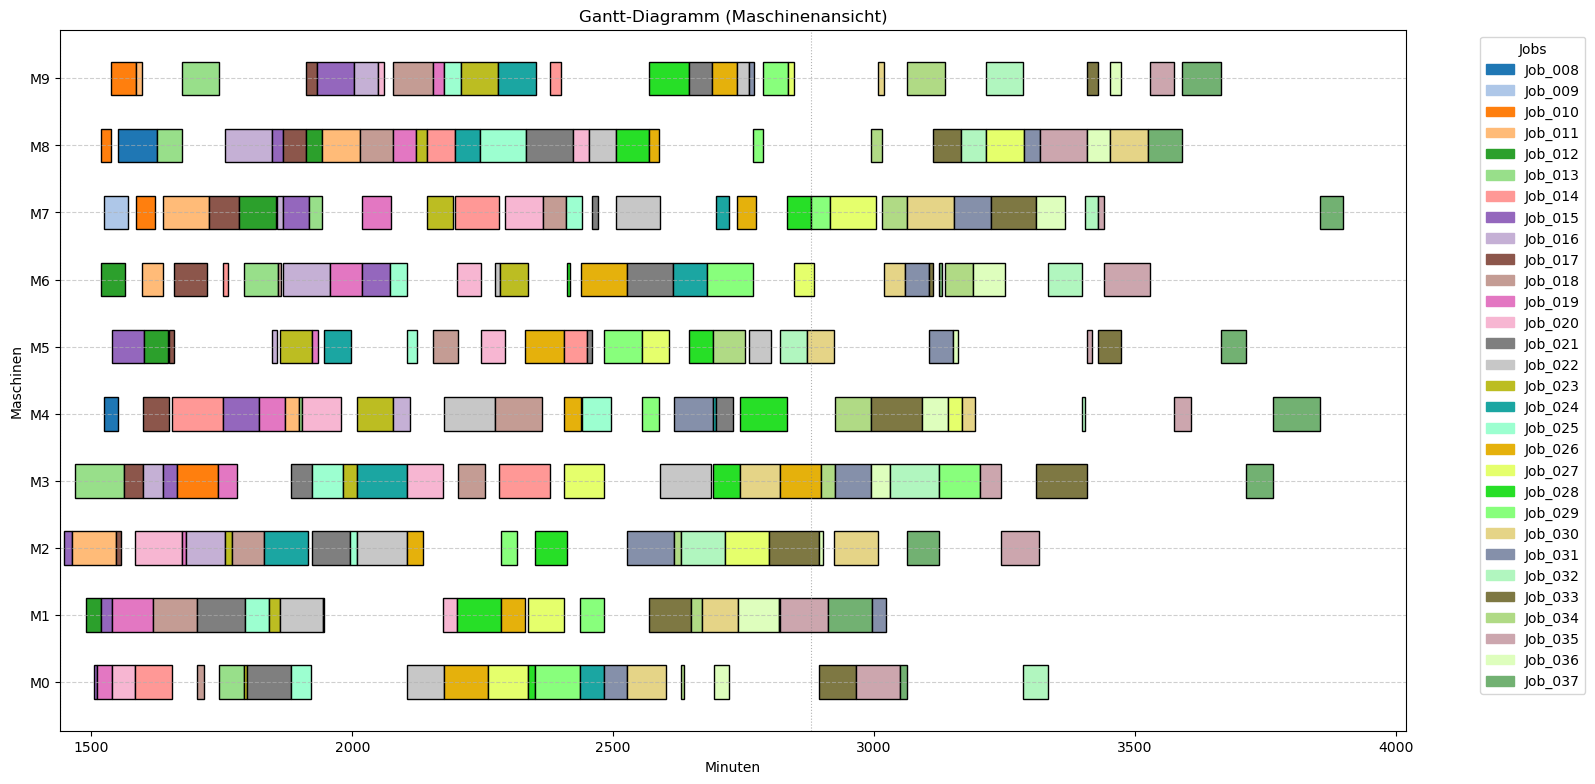

+ Keine Maschinenkonflikte gefunden
+ Für alle Jobs ist die Operationssequenz korrekt.
+ Zeitliche technologische Reihenfolge korrekt.
+ Alle Operation starten erst nach Arrival des Job


True

In [28]:
show.plot_gantt_machines(df_reschedule)
check.is_machine_conflict_free(df_reschedule)
check.is_operation_sequence_correct(df_reschedule)
check.is_job_timing_correct(df_reschedule)
check.is_start_correct(df_reschedule)

In [29]:
show.count_column_grouped(df_reschedule, 'Tardiness')

<0             0
0            259
0-30           0
30-60          0
60-120         0
120-240        0
240-480        0
480-720        0
720-1440       0
1440-2880      0
>2880          0
dtype: int32

### Combi aus Simulation und Neuplannung

In [31]:
# Relevante Spalten
columns_needed = ["Job", "Operation", "Arrival", "Machine", "Start", "Processing Time", "End"]

# Spalte in df_execution umbenennen
df_execution_important_renamed = df_execution.rename(columns={"Simulated Processing Time": "Processing Time"})

# Auf die gewünschten Spalten beschränken
df_exec_trimmed = df_execution_important_renamed[columns_needed]
df_resched_trimmed = df_reschedule[columns_needed]

# DataFrames zusammenführen
df_combined = pd.concat([df_exec_trimmed, df_resched_trimmed], ignore_index=True)
df_combined

,Job,Operation,Arrival,Machine,Start,Processing Time,End
0,Job_000,0,0,M0,0.00,13.20,13.20
1,Job_000,1,0,M1,29.00,107.22,136.22
2,Job_000,2,0,M2,259.87,7.82,267.69
3,Job_000,3,0,M3,267.69,27.73,295.42
4,Job_000,4,0,M4,321.91,96.68,418.59
...,...,...,...,...,...,...,...
375,Job_037,5,2794,M9,3590.00,76.00,3666.00
376,Job_037,6,2794,M5,3666.00,47.00,3713.00
377,Job_037,7,2794,M3,3713.00,52.00,3765.00
378,Job_037,8,2794,M4,3765.00,90.00,3855.00


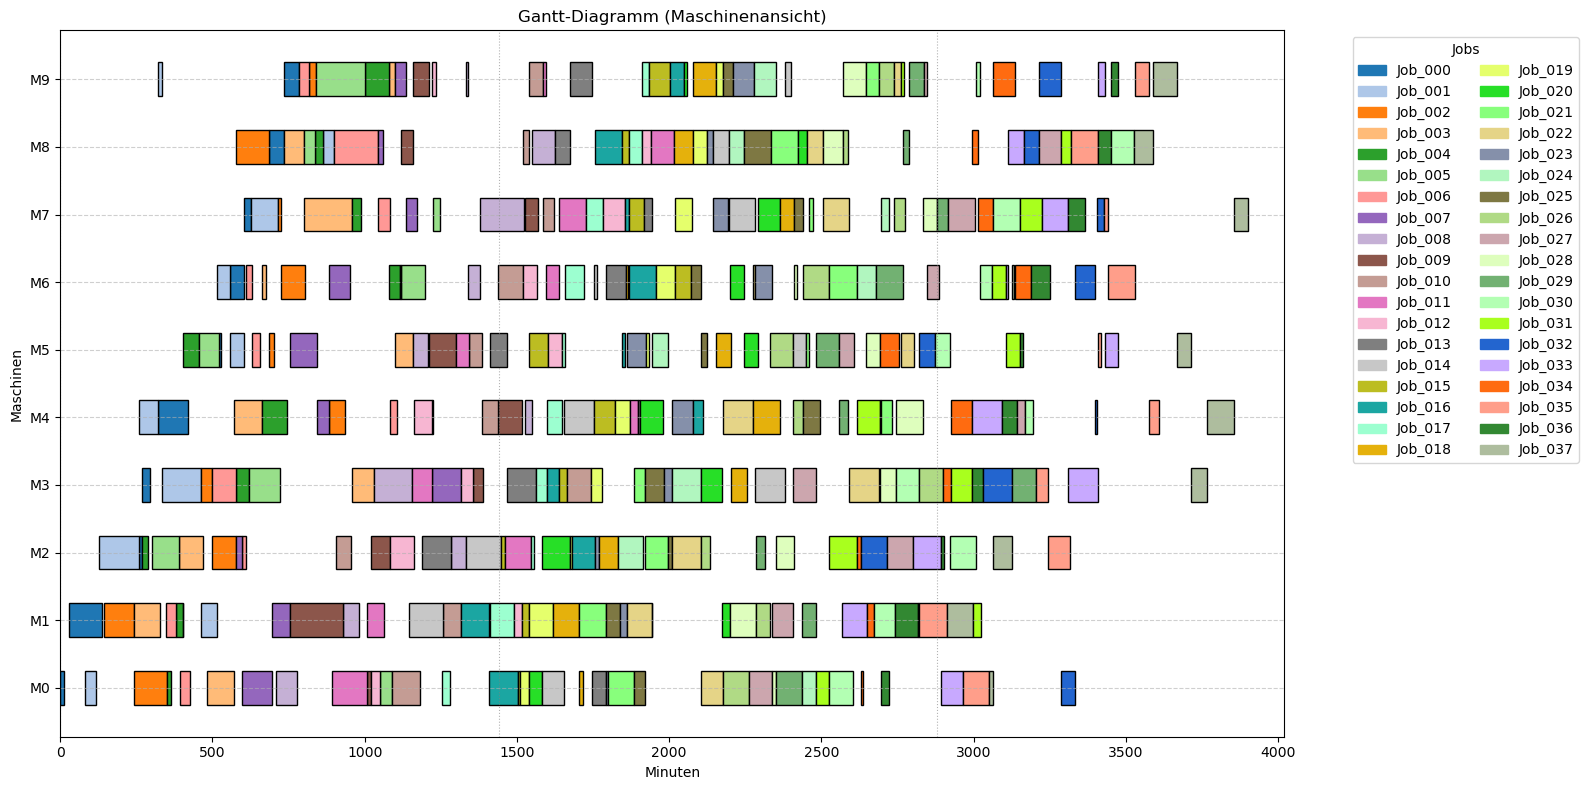

+ Keine Maschinenkonflikte gefunden
+ Für alle Jobs ist die Operationssequenz korrekt.
+ Zeitliche technologische Reihenfolge korrekt.
+ Alle Operation starten erst nach Arrival des Job


True

In [32]:
show.plot_gantt_machines(df_combined)
check.is_machine_conflict_free(df_combined)
check.is_operation_sequence_correct(df_combined)
check.is_job_timing_correct(df_combined)
check.is_start_correct(df_combined)